In [65]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report
from sklearn.linear_model import LogisticRegression

from pathlib import Path
import pickle
# May require pip installation
from tqdm.auto import tqdm

from importlib import reload

import sys
sys.path.append("../src")

import utils

In [2]:
plt.rcParams.update({'font.size': 22, 'figure.figsize': (12, 8)})
plt.style.use("seaborn")

f_path = Path("../data/bank-full.csv")

df = pd.read_csv(f_path, delimiter=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [7]:
RANDOM_STATE = 42

import utils
reload(utils)
df_drop = df.drop(['job', 'month'], axis=1)
X_train, X_test, y_train, y_test, scaler = utils.preprocess(df, random_state=RANDOM_STATE)
X_train

,day,campaign,pdays,previous,age_transf,balance_transf,duration_transf,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
41626,25,1,-1,0,1.041921,-0.408664,-0.594750,0,0,0,...,0,0,0,0,0,0,1,0,0,1
31347,16,13,-1,0,-1.218254,-0.296667,-0.680179,0,0,0,...,0,0,1,0,0,0,0,0,0,1
22563,22,1,-1,0,-0.464863,-0.396183,-0.528737,0,0,0,...,0,0,0,0,0,0,0,0,0,1
37243,13,1,-1,0,1.324443,-0.341334,-0.225854,0,1,0,...,0,0,0,1,0,0,0,0,0,1
32259,16,1,339,1,-0.276515,-0.150513,0.399328,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,18,1,-1,0,0.288529,-0.099605,7.124890,0,0,1,...,0,1,0,0,0,0,0,0,0,1
44732,8,1,92,1,-1.689124,-0.280574,-0.187023,0,0,0,...,0,0,0,0,0,0,1,0,0,0
38158,15,1,-1,0,-0.653211,-0.014869,-0.074413,0,0,0,...,0,0,0,1,0,0,0,0,0,1
860,7,1,-1,0,-0.747384,-0.393227,-0.571452,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [71]:
y_train

41626    0
31347    0
22563    0
37243    0
32259    0
        ..
11284    1
44732    0
38158    0
860      0
15795    0
Name: y, Length: 33908, dtype: int32

# Baseline Model

In [4]:
%%time
log = LogisticRegression(max_iter=1000, class_weight=None,random_state=RANDOM_STATE)
log.fit(X_train, y_train)

Wall time: 4.65 s


LogisticRegression(max_iter=1000, random_state=42)

# Add Class Weights

In [5]:
%%time
log_weight = LogisticRegression(max_iter=1000, class_weight='balanced',random_state=RANDOM_STATE)
log_weight.fit(X_train, y_train)

Wall time: 3.91 s


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Hyperparameter Tuning

### First for the original training data X_train

In [51]:
model_base = LogisticRegression(max_iter=10000, C=3, random_state=RANDOM_STATE)

paramgrid = {#'C': [0.1, 0.3, 0.6, 1, 3, 6, 10],
    'class_weight': [None, 'balanced', {1:2, 0:1}, {1:10, 0:1}, {1:100, 0:1}, {1:1000, 0:1}]}

# adboost_paramgrid = {"n_estimators": range(40, 60, 5),
#               "learning_rate": range(1, 2)}

# Use f1 macro score as scoring metric to penalise class imbalance (not needed if SMOTE used)
gs = GridSearchCV(model_base, paramgrid, verbose=True)
gs.fit(X_train, y_train)
log_gs = gs.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.3min finished


In [54]:
log_gs

LogisticRegression(C=3, max_iter=10000, random_state=42)

# Overview of Logistic Regression Model Performance

-------------------------------------------------------------------
Baseline


Train
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     29972
           1       0.66      0.35      0.45      3936

    accuracy                           0.90     33908
   macro avg       0.79      0.66      0.70     33908
weighted avg       0.89      0.90      0.89     33908

Test
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      9950
           1       0.64      0.34      0.45      1353

    accuracy                           0.90     11303
   macro avg       0.78      0.66      0.70     11303
weighted avg       0.88      0.90      0.88     11303

-------------------------------------------------------------------
Weighted


Train
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     29972
           1       0.42      0.82      0.55      3936

    acc

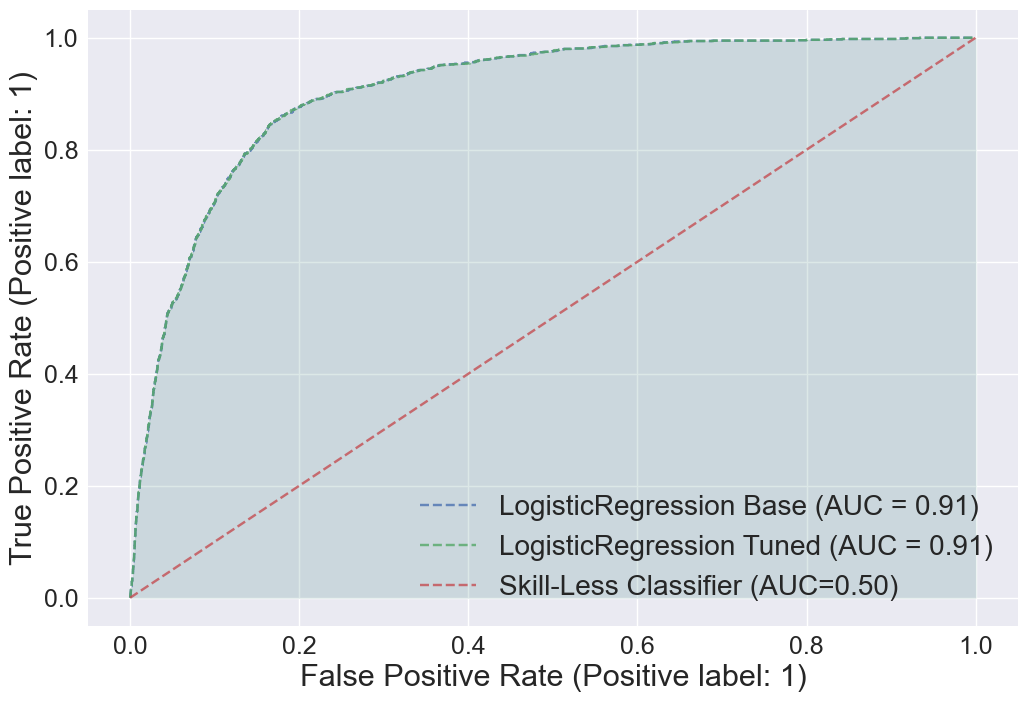

In [76]:
def predictions(estimator, X_train, X_test, y_train, y_test):
    y_hat_train = estimator.predict(X_train)
    y_hat_test = estimator.predict(X_test)
    return [y_train, y_hat_train, y_test, y_hat_test]

def get_metrics(clfs, X_trains, X_tests, y_trains, y_tests, labels):

    if isinstance(clfs, list):
        for i, clf in enumerate(clfs):
            print('-------------------------------------------------------------------')
            print(labels[i])
            print('\n')
            print('Train')
            print(classification_report(y_trains[i],clf.predict(X_trains[i])))
            print('Test')
            print(classification_report(y_tests[i],clf.predict(X_tests[i])))
clfs = [log, log_weight, log_gs]
X_trains = [X_train, X_train, X_train]
X_tests = [X_test, X_test, X_test]
y_trains = [y_train, y_train, y_train]
y_tests = [y_test, y_test, y_test]
labels = ['Baseline', 'Weighted', 'GridSearch']

get_metrics(clfs, X_trains, X_tests, y_trains, y_tests, labels)

plt.style.use("seaborn")

plots_dir = Path("../plots/adaboost")

if not plots_dir.is_dir():
    plots_dir.mkdir()

reload(utils)
plt.rcParams.update({'font.size': 14,
                    'axes.labelsize': 22,
                    'xtick.labelsize': 18,
                    'ytick.labelsize': 18})

utils.plot_roc_curve([log, log_gs], X_test, y_test,
                    labels=["LogisticRegression Base", "LogisticRegression Tuned"],
                    subplots_kwargs={"figsize": (12, 8)},
                    save_fpath=plots_dir/"logistic_regression_roc.png")

plt.show()

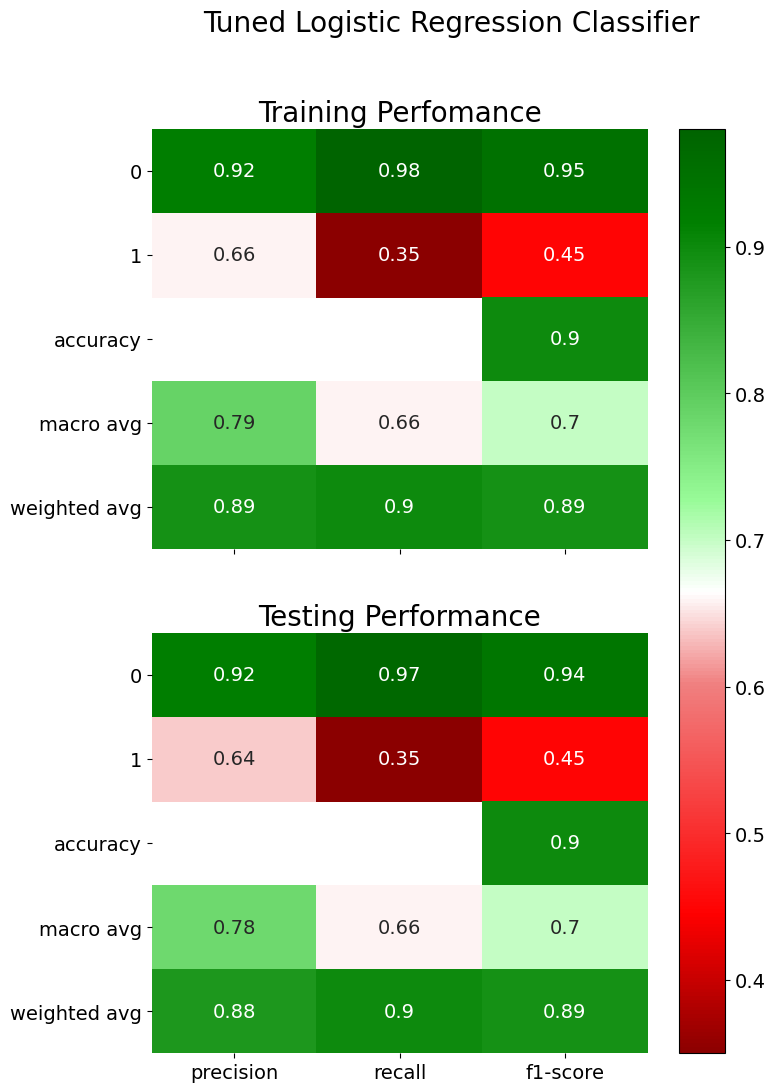

In [74]:

reload(utils)
plt.style.use("default")

plt.rcParams.update({'font.size': 14,
                    'axes.labelsize': 20,
                    'axes.titlesize': 20})

report_df = utils.compare_classification_reports([log_gs, log_gs],
                                                 [X_train, X_test],
                                                 [y_train, y_test],
                                                 names=["Training Perfomance", "Testing Performance"],
                                                 suptitle="Tuned Logistic Regression Classifier",
                                                 plot=True,
                                                 subplot_kwargs=dict(nrows=2, figsize=(8, 12)),
                                                 cbar_orient="vertical",
                                                  save_fpath=plots_dir/"logistic_regression_best_report.png")

**This suggests the GridSearch model is best** (note that the GridSearch selected the model with no class weights was selected over the balanced one).

In [55]:
models_dir = Path("../models/logistic_regression")

assert models_dir.is_dir()

data_dir = models_dir/"data"

if not data_dir.is_dir():
    data_dir.mkdir()
    
pickle.dump(log, open(models_dir/"log_base.p", "wb"))
pickle.dump(log_weight, open(models_dir/"log_weight.p", "wb"))
pickle.dump(log_gs, open(models_dir/"log_gs.p", "wb"))
pickle.dump((X_train, X_test, y_train, y_test), open(data_dir/"data.p", "wb"))

with open(models_dir/"README.md", "w") as f:
    f.write(f"""
    ## Logistic regression models trained on original data
    Contents:
    - `log_base.p` - trained LogisicRegression instance (baseline classifier)
    - `log_weight.p` - trained LogisicRegression instance (baseline classifier with class_weights='balanced')
    - `log_gs.p` - trained LogisicRegression instance (best classifier)
    - `data.p` - data tuple (X_train, X_test, y_train, y_test)
    """)